In [0]:
import numpy as np
import matplotlib.pyplot as plt
# Import some useful packages
import tensorflow as tf
import tensorflow.keras.backend as K

# Layers for FNN
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda, concatenate, BatchNormalization, Add, ReLU
from tensorflow.keras.layers import Dense

# Optimizers for training
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import metrics

# Losses for training
from tensorflow.keras import losses

# For data preprocessing
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical

載入資料和標準化

In [0]:
# Load dataset
(X_train, y_train0), (X_test, y_test0) = datasets.mnist.load_data()

# Reshape size
X_train = X_train.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)

# Normalize the range of featurs
X_train = X_train / X_train.max()
X_test = X_test / X_test.max()

# One-hot encoding
y_train = to_categorical(y_train0, 10)
y_test = to_categorical(y_test0, 10)

定義「抽樣」函數

In [0]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

建立VAE模型

In [0]:
# Encoder part

x = Input(shape=(784,))
enc = Dense(256, activation='sigmoid')(x)
enc1 = Dense(256, activation= 'sigmoid')(enc)
enc1 = BatchNormalization()(enc1)
enc1 = ReLU()(enc1)
enc = Add()([enc, enc1])
enc = Dense(128, activation='sigmoid')(enc)
Enc_mean = Dense(2)(enc)
Enc_log_var = Dense(2)(enc)

#Decoder part

z_input = Input(shape=(2,))
dec_1 = Dense(128, activation='sigmoid')
dec_2 = Dense(256, activation='sigmoid')
dec_3 = Dense(784, activation='sigmoid')
x_hat = dec_3(dec_2(dec_1(z_input)))


#Enccoder model
VAE_Encoder = Model(inputs=x, outputs=[Enc_mean,Enc_log_var])
#Decoder model
VAE_Decoder = Model(inputs=z_input, outputs=x_hat)
#VAE model
z = Lambda(sampling, output_shape=(2,))([Enc_mean,Enc_log_var])
x_hat = dec_3(dec_2(dec_1(z)))
VAE = Model(inputs=x, outputs=x_hat)

In [46]:
VAE.summary()


Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_40 (Dense)                (None, 256)          200960      input_11[0][0]                   
__________________________________________________________________________________________________
dense_41 (Dense)                (None, 256)          65792       dense_40[0][0]                   
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 256)          1024        dense_41[0][0]                   
___________________________________________________________________________________________

In [47]:
VAE_Encoder.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_40 (Dense)                (None, 256)          200960      input_11[0][0]                   
__________________________________________________________________________________________________
dense_41 (Dense)                (None, 256)          65792       dense_40[0][0]                   
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 256)          1024        dense_41[0][0]                   
___________________________________________________________________________________________

In [48]:
VAE_Decoder.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_45 (Dense)             (None, 128)               384       
_________________________________________________________________
dense_46 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_47 (Dense)             (None, 784)               201488    
Total params: 234,896
Trainable params: 234,896
Non-trainable params: 0
_________________________________________________________________


定義損失函數

（放棄理解

In [0]:
reconstruction_loss = 784 * losses.mean_squared_error(x, x_hat)

kl_loss = 1 + Enc_log_var - K.square(Enc_mean) - K.exp(Enc_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)

VAE.add_loss(vae_loss)

In [0]:
VAE.compile(optimizer=Adam())

In [41]:
mycallback = [tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=50, verbose=0, mode='auto', baseline=None, restore_best_weights=False)]

VAE.fit(X_train, X_train, 
        callbacks=mycallback,
        batch_size = 4096, 
        epochs = 500)

Epoch 1/500
15/15 [==============================] - 3s 187ms/step - loss: 55.2340
Epoch 2/500
15/15 [==============================] - 3s 185ms/step - loss: 54.8970
Epoch 3/500
15/15 [==============================] - 3s 185ms/step - loss: 54.9638
Epoch 4/500
15/15 [==============================] - 3s 183ms/step - loss: 54.9441
Epoch 5/500
15/15 [==============================] - 3s 188ms/step - loss: 55.0044
Epoch 6/500
15/15 [==============================] - 3s 185ms/step - loss: 55.0730
Epoch 7/500
15/15 [==============================] - 3s 184ms/step - loss: 55.0559
Epoch 8/500
15/15 [==============================] - 3s 187ms/step - loss: 55.5161
Epoch 9/500
15/15 [==============================] - 3s 185ms/step - loss: 55.4324
Epoch 10/500
15/15 [==============================] - 3s 185ms/step - loss: 55.1441
Epoch 11/500
15/15 [==============================] - 3s 186ms/step - loss: 55.2567
Epoch 12/500
15/15 [==============================] - 3s 186ms/step - loss: 55.2716
E

In [38]:
import os
from google.colab import drive
drive.mount('/content/drive/')

path = "/content/drive/My Drive/Colab Notebooks/"

os.chdir(path)
os.listdir(path)
VAE.save_weights('VAE_weight.h5')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [51]:
import os
from google.colab import drive
drive.mount('/content/drive/')

path = "/content/drive/My Drive/Colab Notebooks/"

os.chdir(path)
os.listdir(path)
VAE.load_weights('VAE_weight.h5')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Encoder 視覺化

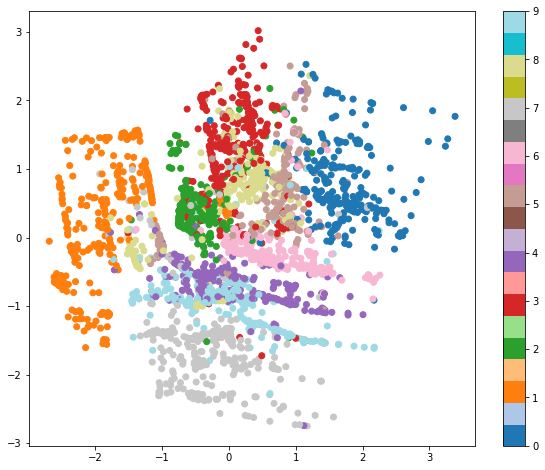

In [52]:
indices = np.random.randint(X_train.shape[0], size=3000)
VAE_latents = VAE_Encoder.predict(X_train[indices])[0]

plt.figure(figsize=(10, 8))
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_train0[indices], cmap='tab20')
plt.colorbar()
plt.show()

Decoder 視覺化

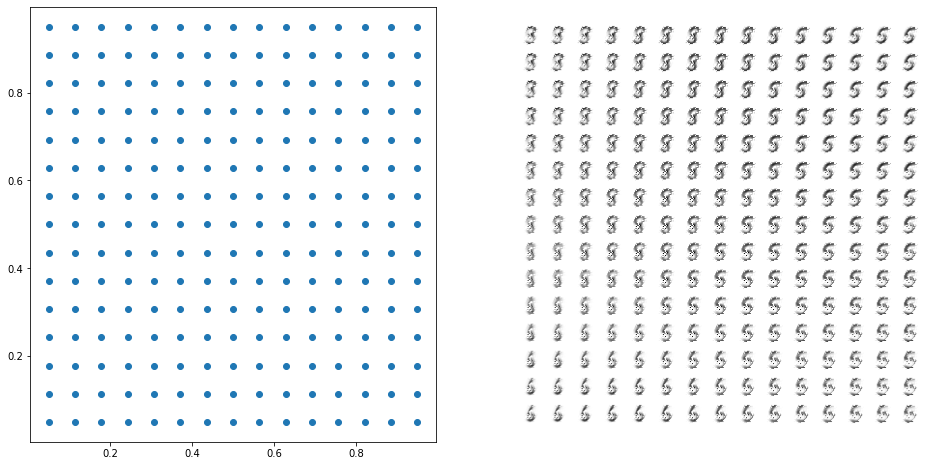

In [53]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(0.05 , 0.95, n)
grid_y = np.linspace(0.05, 0.95, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[(n-i-1) * digit_size: (n - i) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
XX, YY = np.meshgrid(grid_x, grid_y)
plt.scatter(XX, YY)

plt.subplot(1, 2, 2)
plt.imshow(figure, cmap='Greys')
plt.axis('off')
plt.show()
